# Using K-Means Clustering to Predict the 2022 NBA Playoffs
#### *By Jonah Wiener-Brodkey*

## Motivation

For basketball fans, the two months from mid-April to mid-June make up the most wonderful time of the year. It's the Playoffs! 16 teams will vie for a championship. New stars will emerge, narratives will take shape, and legacies will solidify. The 2022 playoffs will be especially exciting because of the lack of a clear favorite to win it all. It seems like the Suns, Heat, Nets, Warriors, Celtics, and Bucks all have a legitimate case.  

In any year, there's a desire to predict who will come out on top, whether for betting purposes or just for fun. In a year as open as this, the use of analytics for making predictions feels all the more relevant.  

One way people try to evaluate playoff matchups is by comparing regular-season records. It's pretty intuitive that the team that won more of its games in the regular season probably has better odds in the playoffs. But that's not always the case, as upsets sometimes happen. And when it gets to the later stages of the playoffs and all the teams remaining had strong regular-season records, it gets harder to distinguish between teams on that basis.  

This approach also has its limits when you're comparing head-to-head matchups. To evaluate Team A's odds in a matchup against Team B, we could look at how those teams performed against each other in the regular season. However, any two teams only play each other a maximum of 4 times in a season. There's a lot of natural variability in basketball—even the best teams lose 10-25% of their games—and a 4-game regular-season series probably isn't enough to tell us definitively whether Team A is better or worse than Team B.  

In this analysis, I attempt to use K-means clustering to solve this problem and make better-informed predictions. K-means clustering, briefly, is an unsupervised machine learning algorithm that divides data points between K different groups called clusters. It does so by minimizing the distance between points in a cluster and maximizing the distance between neighboring clusters. So we can think of every point in a cluster as being similar to one another but distinct from points in other clusters.  

Here, I sort every team in the NBA into clusters, using their statistics from the 2021-2022 season to group teams that are statistically similar to each other. This way, when we ask how Team A will do in a playoff series against Team B, we can compare not just each Team A's regular-season record against Team B, but also Team A's record against the other teams in Team B's cluster, since these teams are "like" Team B. Our sample size is much higher in this case—some teams play a given cluster over 40 times. We can do the same for Team B's regular-season performance against the other teams in Team A's cluster.  

For each playoff series, I look at the regular-season record between the two teams, the regular-season record between each team and the other's cluster, and a variety of standard basketball statistics, including each team's offensive and defensive rating, shooting numbers, turnovers, and more. I also take a qualitative approach in that I consider recent injuries, take into account star power, and do a fair amount of listening to my gut. Accounting for all these factors, I predict two things: the **winner** of each series and the **length** of each series, e.g. **Phoenix in 4**.  

This approach has its flaws, which I'll talk about later, but at the very least it offers a new way of thinking about how two teams stack up against each other. It's analytics at its core, but with a qualitative flavor that I think is refreshing in this analytics-obsessed world.  

Let's see what I actually did for this project, and then how our results looked.

## Methodology

First, I scraped every team's regular-season statistics from basketball-reference.com. This dataset included over 40 features for every team, including both standard and advanced statatistics.  

I then used principal component analysis (PCA) to reduce the number of variables for every team in the dataset. While having a lot of data is great, it's harder to interpret the results and we run the risk of overfitting in our cluster analysis. Instead, I just used the principal components that, together, account for a significant amount of the variance in the data.  

Next, I applied K-means clustering, using an elbow plot to select the number of clusters, K, to identify natural clusters of teams. Then, for each playoff matchup, I looked at not only the regular-season record between the two teams, but also between each team and the other team's cluster. For example, for the first-round matchup between Phoenix and New Orleans, looked at how Phoenix performed against team's in New Orleans's cluster (i.e. teams "like" New Orleans) and how New Orleans performed against Phoenix's cluster.  

*Terminology note:* Throughout this analysis, if two teams are in different clusters, I'll refer to their **intercluster** performance. If they wind up in the same cluster, I'll refer to their **intracluster** performance.  


### Measuring accuracy

Once the playoffs have concluded, there will be two metrics for accuracy:  

1) The % of series winners correctly predicted (i.e. the number of correct winners divided by 15, the total number of playoff series).  

2) The average absolute error in series length. This metric will be based on the difference between the predicted and actual margin of games in a series. For example, if we predict that Phoenix will beat New Orleans in 6 (4 games to 2, for a margin of +2) games but Phoenix acually wins in 4 (4 games to 0 for a margin of +4), the error for this series will be 2. (We will use absolute values so the direction of error doesn't matter.) The same applies if the error involves mispredicting the winner of the series. If we predict that Phoenix will beat New Orleans in 6 games (4 games Phoenix, 2 games New Orleans: margin +2 for Phoenix) but it's actually New Orleans that wins the series in 6 (2 games Phoenix, 4 games New Orleans: margin -2 for Phoenix), the error for this series will be 4 (that is, 2 - (-2) = 2 + 2). This metric will be averaged across all series EXCEPT those involving teams different from what we predicted. So, if we predict Phoenix and Dallas will meet in the second round but Phoenix gets eliminated in the first round, this error will be reflected in the accuracy metric described in 1) but not the error metric described in 2). The second-round series involving Dallas wouldn't contribute to the error metric at all.

## Data import/retrieval

In [2]:
import pandas as pd
import numpy as np
import requests
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
# define URLs
## traditional stats URL
url_trad = 'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2021-22&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='
## advanced stats URL
url_adv = 'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2021-22&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='
header_dict = {
    'User-Agent': 'Mozilla/5.0',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true',
    'Referer': 'https://stats.nba.com',
    'Connection': 'keep-alive',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
    'Host': 'stats.nba.com'
}
# traditional stats
res_trad = requests.get(url_trad, headers=header_dict)
json_set_trad = res_trad.json()
headers_trad = json_set_trad['resultSets'][0]['headers']
data_set_trad = json_set_trad['resultSets'][0]['rowSet']
df_trad = pd.DataFrame(data_set_trad, columns=headers_trad)
df_trad.head()

# advanced stats
res_adv = requests.get(url_adv, headers=header_dict)
json_set_adv = res_adv.json()
headers_adv = json_set_adv['resultSets'][0]['headers']
data_set_adv = json_set_adv['resultSets'][0]['rowSet']
df_adv = pd.DataFrame(data_set_adv, columns=headers_adv)

## Data cleaning

In [2]:
# join columns and drop ID, Games Played, Wins and Losses, Win %, Minutes, CFID, and CFParams
df = pd.concat([df_trad, df_adv.iloc[:,7:]], axis = 1)
df.drop(['TEAM_ID','GP','W','L','W_PCT','MIN','CFID','CFPARAMS'], axis = 1, inplace = True)

NameError: name 'df_trad' is not defined

In [ ]:
# get rid of rank columns
df = df.iloc[:,~df.columns.str.endswith('RANK')]

# rename teams with team codes
df['TEAM_NAME'] = ['ATL','BOS','BKN','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM','MIA','MIL','MIN',
                   'NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

In [ ]:
# save snapshot of the data before the page updates

df.to_csv('Combined_Team_Data.csv', index = False)

In [3]:
# data as it looked on Sunday, April 10th (the last day of the regular season)
# dataset is available for download in this github repo

df = pd.read_csv('Combined_Team_Data.csv')

## Scaling and centering + PCA

In [4]:
df_scaled = preprocessing.StandardScaler().fit_transform(df.iloc[:,1:])

pca = PCA()
pca.fit(df_scaled)
pca_data = pca.transform(df_scaled)

In [5]:
# get percent variance
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

print(per_var[:5])
print(labels[:5])

[31.25 16.97 11.74 10.05  8.27]
['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


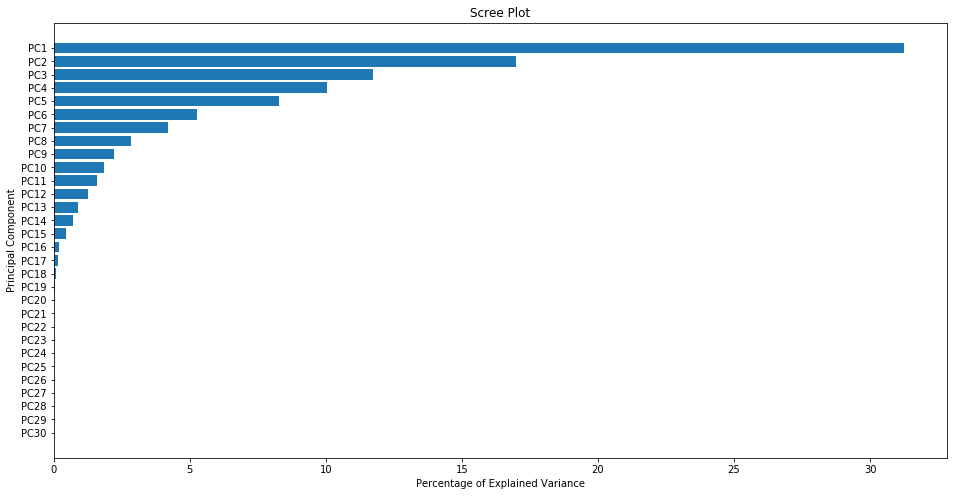

In [20]:
# show bar plot of variance explained by component
plt.figure(figsize = (16,8))

plt.barh(y=range(1,len(per_var)+1), width=per_var, tick_label=labels)
plt.gca().invert_yaxis()
plt.xlabel('Percentage of Explained Variance')
plt.ylabel('Principal Component')
plt.title('Scree Plot')
#plt.savefig('NBA Predictions 2022 Scree Plot.png')
plt.show();

In [ ]:
pd.DataFrame(pca_data, columns = labels)

In [21]:
# first 3 components labeled with team names
pca_df = pd.concat([df.TEAM_NAME, pd.DataFrame(pca_data, columns = labels).loc[:,'PC1':'PC3']], axis = 1)
labeled_pca_df = pca_df.set_index('TEAM_NAME').loc[:,'PC1':'PC3']
labeled_pca_df.head()

,PC1,PC2,PC3
TEAM_NAME,,,
ATL,-2.917097,-0.556654,-0.998391
BOS,-4.298678,-1.619742,1.600459
BRK,-1.114038,1.287088,-1.050472
CHA,-1.918959,4.587520,-2.074291
CHI,-0.823859,-1.399621,-2.292584


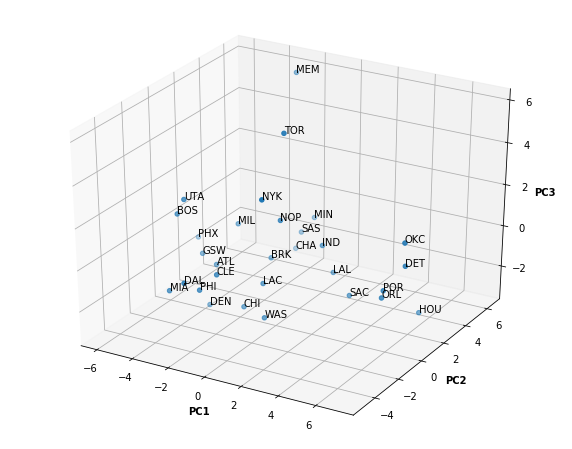

In [22]:
# 3d scatterplot

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(labeled_pca_df['PC1'],labeled_pca_df['PC2'],labeled_pca_df['PC3'])
ax.set_xlabel('PC1', fontweight = 'bold')
ax.set_ylabel('PC2', fontweight = 'bold')
ax.set_zlabel('PC3', fontweight = 'bold')
for sample in range(len(labeled_pca_df.index)):
    ax.text(labeled_pca_df.PC1[sample],labeled_pca_df.PC2[sample],labeled_pca_df.PC3[sample], labeled_pca_df.index[sample])
plt.show()

## K means analysis

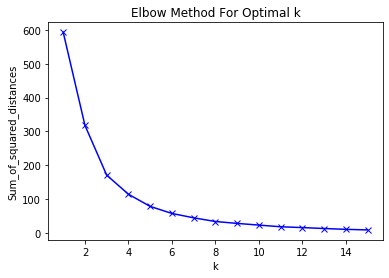

In [23]:

# selecting K via elbow method
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k, random_state = 0)
    km = km.fit(pca_df.iloc[:,1:3])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
# clustering

km_data = labeled_pca_df.loc[:,'PC1':'PC3']

km = KMeans(n_clusters = 5, random_state = 0)
model = km.fit(km_data)

preds = model.fit_predict(km_data)

clustered_data = pd.concat([df['TEAM_NAME'], km_data.reset_index(drop = True), pd.Series(preds)], axis = 1)
clustered_data.columns = ['TEAM_NAME', 'PC1','PC2','PC3','CLUSTER']

clustered_data.head()

,TEAM_NAME,PC1,PC2,PC3,CLUSTER
0,ATL,-2.917097,-0.556654,-0.998391,0
1,BOS,-4.298678,-1.619742,1.600459,0
2,BRK,-1.114038,1.287088,-1.050472,4
3,CHA,-1.918959,4.587520,-2.074291,4
4,CHI,-0.823859,-1.399621,-2.292584,0


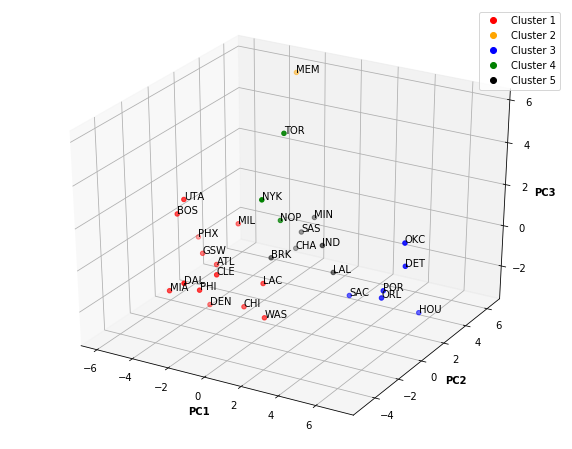

In [26]:
# 3d scaterplot with clusters

colors = {0:'red',1:'orange',2:'blue',3:'green',4:'black'}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(clustered_data['PC1'],clustered_data['PC2'],clustered_data['PC3'], c = clustered_data['CLUSTER'].map(colors))
ax.set_xlabel('PC1', fontweight = 'bold')
ax.set_ylabel('PC2', fontweight = 'bold')
ax.set_zlabel('PC3', fontweight = 'bold')
for sample in range(len(clustered_data)):
    ax.text(clustered_data.PC1[sample],clustered_data.PC2[sample],clustered_data.PC3[sample], clustered_data.TEAM_NAME[sample])
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[0], marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[1], marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[2], marker = 'o')
scatter4_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[3], marker = 'o')
scatter5_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[4], marker = 'o')
#scatter6_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[5], marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy, scatter4_proxy, scatter5_proxy],
          ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'], numpoints = 1)
#plt.show()
plt.savefig('NBA Predictions 2022 Clusters.png');

In [ ]:
np.linalg.norm(labeled_pca_df.set_index('TEAM_NAME',drop=True).loc['TOR']-labeled_pca_df.set_index('TEAM_NAME',drop=True).loc['MEM'])
np.linalg.norm(labeled_pca_df.set_index('TEAM_NAME',drop=True).loc['TOR']-labeled_pca_df.set_index('TEAM_NAME',drop=True).loc['NYK'])

## Predictions

In [13]:
# remapping clusters to 1-5 instead of 0-4 

team_clusters = clustered_data.loc[:,['CLUSTER','TEAM_NAME']].sort_values('CLUSTER').reset_index(drop=True)
team_clusters.CLUSTER = team_clusters.CLUSTER.map({0:1, 1:2, 2:3, 3:4, 4:5})
team_clusters

,CLUSTER,TEAM_NAME
0,1,ATL
1,1,PHX
2,1,PHI
3,1,MIL
4,1,MIA
5,1,UTA
6,1,LAC
7,1,GSW
8,1,WAS
9,1,DEN


### Round 1

### West

#### 1. Phoenix Suns (PHX) vs 8. New Orleans Pelicans (NOP)

*Head-to-head record: 3-1 PHX*  
*PHX record against NOP cluster (4): 6-2*  
*NOP record against PHX cluster (1): 14-25*  

New Orleans had a historic turnaround to its season, starting the season 1-12 before a late-season surge that left them in play-in position, where they overcame a double-digit deficit against an undermanned Clippers team to secure the 8th seed. Unfortunately, this means the Pelicans are the worst team in the playoffs by just about every metric, and they find themselves in a first-round matchup against the perhaps the best team in the playoffs. New Orleans even underperformed against Phoenix's cluster, going 14-25 (0.359 win %) compared to 36-46 (0.439) on the season overall.

**Prediction: PHX wins in 4 games.**

#### 2. Memphis Grizzlies (MEM) vs 7. Minnesota Timberwolves (MIN)

*Head-to-head record: 2-2*  
*MEM record against MIN cluster (5): 14-4*  
*MIN record against MEM cluster (2): 2-2 (Memphis is its own cluster)*  

This should be a fun, fast series in two of the three highest paced teams take each other on. Memphis and Minnesota split their regular-season series, with each game except one (a 43-point blowout by the T-Wolves) decided by 8 points or fewer. Fueled by their big three and Pat Bev's grit, Minnesota will put up a fight but come short against a better, deeper team.  

**Prediction: MEM wins in 6 games.**

#### 3. Golden State Warriors (GSW) vs 6. Denver Nuggets (DEN)

*Head-to head record: 3-1 DEN*  
*GSW record against DEN cluster (1): 21-16*  
*DEN record against GSW cluster (1): 16-18*  

Although Denver claimed their season series against the Warriors, their performance against the other members of Golden State's cluster (which also happens to be their own cluster) is nothing to write home about, setting the stage for an early playoff exit.

**Prediction: GSW wins in 6 games.**

#### 4. Dallas Mavericks (DAL) vs 5. Utah Jazz (UTA)

*Head-to head record: 2-2*  
*DAL record against UTA cluster (1): 17-17*  
*UTA record against DAL cluster (1): 19-16*  

Are the streaking Mavs for real? This series will be as fun a way as any to find out, with each team winning half its head-to-head games and about half its intracluster games. Owners of the second-best record since the All-Star break and the 6th best defense overall, Dallas will have to contain Utah's #1 offense, which shoots threes at the highest rate in the NBA. And they'll have to do so without Luka Doncic, who will miss Game 1 (and potentially longer) with a calf strain. This series will be close, but the untimely loss of Doncic will prove too much for Dallas to overcome.

**Prediction: UTA wins in 7 games.**

### East

#### 1. Miami Heat (MIA) vs 8. Atlanta Hawks (ATL)

*Head-to-head record: 3-1 MIA*  
*MIA record against ATL cluster (1): 23-17*  
*ATL record against MIA cluster (1): 18-22*  

Atlanta is the NBA's #2 offense and #26 defense. Miami is top-10 in both. Clint Capela being sidelined for at least a week with a knee injury, won't do any favors for the Hawks' bottom-dwelling defense. Atlanta's intracluster record is surprisingly strong at just a few games under .500, but Miami's is still substantially better. Either Miami will take the series with ease, or Trae Young will successfully piss off his 4th fanbase in 2 seasons. As fun as the latter would be, I'm going with the former.

**Prediction: MIA wins in 5 games.**

#### 2. Boston Celtics (BOS) vs 7. Brooklyn Nets (BKN)

*Head-to head record: 3-1 BOS*  
*BOS record against BKN cluster (5): 11-7*  
*BKN record against BOS cluster (1): 17-25*  

The first matchup where the cluster analysis has a hot take. The algorithm apparently doesn't like the Nets, grouping them with only one other playoff team (MIN) and only lottery teams otherwise. This could be because, for the 27 games Kevin Durant missed due to injury, they were a lottery team, going 8-19 over that span. Brooklyn's poor record against Boston's cluster supports a gloomy view of its prospects in the first round, where it must face the NBA's hottest team since the All-Star break. To be fair, Boston won't be at full strength for the first round at least. Starting center Robert Williams suffered a partial meniscus tear with just weeks left in the regular season, and he likely wouldn't be available until the second round at the earliest. With Williams, Boston had a net rating of +7.5. Boston is heavily favored in this analysis; but the Nets still have Kevin Durant and are one of the favorites to win it all on betting markets, so I don't think it will be as close as the cluster analysis would have you believe.

**Prediction: BOS wins in 6 games.**

#### 3. Milwaukee Bucks (MIL) vs 6. Chicago Bulls (CHI)

*Head-to head record: 4-0 MIL*  
*MIL record against CHI cluster (1): 20-17*  
*CHI record against MIL cluster (1): 16-22*  

The defending champs take on a Lonzo Ball-less Chicago team that couldn't wait for the regular season to end, putting up the 7th worst record in the NBA since the All-Star break. The Bulls didn't win a single game against Milwaukee this year. Their 16-22 record against the Bucks' cluster doesn't inspire confidence either. We're looking at the only sweep in the Eastern Conference.

**Prediction: MIL wins in 4 games.**

#### 4. Philadelphia 76ers (PHI) vs 5. Toronto Raptors (TOR)

*Head-to head record: 3-1 TOR*  
*PHI record against TOR cluster (4): 5-5*  
*TOR record against PHI cluster (1): 24-19*  

Toronto is a hard team to judge in this analysis. The algorithm puts them in a cluster with New Orleans and New York, two teams far below them in the standings. Yet Toronto boasts a respectable 24-19 record against the cluster containing Philadelphia, their first-round opponent. In addition, the Raptors beat the 76ers in 3 out of 4 matchups this year, with each game decided by 6 or fewer points. Because Toronto's cluster is smaller, its harder to gauge Philadelphia's performance against teams like the Raptors (5-5 in regular season games). These teams are incredibly evenly-matched -- its tempting to give Philly the edge because of Joel Embiid's MVP play this season, but I'm going to trust the cluster analysis on this one.

**Prediction: TOR wins in 7 games.**

### Round 2

### West

#### 1. Phoenix Suns (PHX) vs 5. Utah Jazz (UTA)

*Head-to-head record: 3-1 PHX*  
*PHX record against UTA cluster (1): 24-10*  
*UTA record against PHX cluster (1): 19-16*  

Phoenix and Utah are 2nd and 3rd in the NBA in Basketball-Reference.com's Simple Rating System (an estimate of team strength based on point differential, adjusting for strength of schedule). Both are top-5 in offensive rating and shooting. By many metrics, this would shape up to be a close series. That there is still such a big gap between each team's intracluster performance (0.543 win percentage for Utah vs 0.705 for Phoenix, against the cluster that contains most of the NBA's top teams) speaks to how dominant a season the Suns have had. The only team with a top-4 offense and defense, Phoenix might drop a few games but will win the series.


**Prediction: PHX wins in 6 games.**

#### 2. Memphis Grizzlies (MEM) vs 3. Golden State Warriors (GSW)

*Head-to-head record: 3-1 MEM*  
*MEM record against GSW cluster (1): 23-15*  
*GSW record against MEM cluster (2): 1-3 (Memphis is its own cluster)*  

Given Memphis's unique position in a cluster of its own, it's hard to evaluate Golden State's chances going by intercluster performance alone. The Warriors' performance against Cluster 1, which includes most of the NBA's best teams, was strong, as they went 21-16 for a win percetange of 0.568. They were tied with Boston for the NBA's best defense, allowing only 106.9 points per 100 possessions. While their offense was only #17 in the league, their point differential was still strong enough to produce a Pythagorean record (expected number of wins and losses based on points scored and allowed) exactly equal to Memphis's at 55-27 despite a significantly harder schedule. The Warriors' share of shots that are threes is second-highest in the NBA. But Memphis doesn't defend the three particularly well - out of the 16 playoff teams, the Grizzlies are only #9 in defensive three-point percentage. It might not be the most data-driven prediction, but it's hard not to pick Golden State for its stark advantage in playoff experience over a younger but promising Grizzlies team.

**Prediction: GSW wins in 7 games.**

### East

#### 1. Miami Heat (MIA) vs 5. Toronto Raptors (TOR)

*Head-to-head record: 2-2*  
*MIA record against TOR cluster (4): 6-3*  
*TOR record against MIA cluster (1): 24-19*  

Miami and Toronto split their season series, with each game decided by 5 or fewer points. Although the sample size is small due to Toronto's smaller cluster, Miami has a strong intercluster 0.667 win percentage to Toronto's 0.558. (Miami only lost 3 games against Toronto's cluster, two of which came against Toronto and one against the Knicks after blowing a 15-point lead heading into the 4th quarter.) One area to watch will be turnovers. In the regular season, the Raptors led the league in opponent turnover percentage, forcing 16.3 turnovers per 100 possessions and recoring 9 steals a game, good for 2nd in the NBA. While Miami also excels at forcing turnovers, it also commits a lot of turnovers. The Heat ranked #28 of 30 teams in turnover rate, losing the ball on a whopping 13.4% of its possessions. Whether Toronto's advantage here matters is up for debate. If they can keep the steals up, they could steal a few games from the series favorite.

**Prediction: MIA wins in 6 games.**

#### 2. Boston Celtics (BOS) vs 3. Milwaukee Bucks (MIL)

*Head-to-head record: 2-2*  
*BOS record against MIL cluster (1): 19-18*  
*MIL record against BOS cluster (1): 20-17*  

By record, Boston and Milwaukee are evenly matched. Each team beat the other twice at home and lost twice away. Each team posted a win percentage a bit over 0.500 in intracluster competition. The big caveat here is that Boston turned its season around in dramatic fashion, going 20-21 in the first half of the season before posting the best record in the league after the All-Star break. Similarly, through the first 19 games against Cluster 1 teams, the Celtics went 6-13. They would go 13-5 the rest of the season, winning games against Cluster 1 at a rate comparable to that of Phoenix. Indeed, Boston won 8 games fewer than its Pythagorean win total of 59, which is exactly identical to Phoenix's. The Bucks may be the defending champs, but the numbers say Boston is the real deal.

**Prediction: BOS wins in 7 games.**

### Conference Finals

### West

#### 1. Phoenix Suns (PHX) vs 3. Golden State Warriors (GSW)

*Head-to-head record: 2-2 *  
*PHX record against GSW cluster (1): 24-10*  
*GSW record against PHX cluster (1): 21-16*  

The top 2 seeds in the West for much of the early season, Phoenix and Golden State each want to get back to the Finals. For Phoenix, it would be its second Finals appreance in a row. Golden State hasn't been since 2019. If Steph, Klay, Draymond, and newest Splash Bro Jordan Poole stay healthy and continue to boast the NBA's best defensive rating, the Warriors' case for a return to the Finals will be strong. If the Warriors fall subject to their worst tendencies and continue to turn the ball over at the second-worst rate in the NBA (13.5% of all possessions), it will be an uphill climb. Going by intracluster record, Phoenix looks poised to return to the Finals.


**Prediction: PHX wins in 6 games.**

### East

#### 1. Miami Heat (MIA) vs 2. Boston Celtics (BOS)

*Head-to-head record: 2-1 BOS*  
*MIA record against BOS cluster (1): 23-17*  
*BOS record against MIA cluster (1): 19-18*  

Boston won the season series, although one of its wins came in a 30-point blowout against an undermanned Miami team. Although Miami boasts the better record on the season and intraclusterally (?) Boston has the advantage overall. The Celtics' defense was smothering this season. While the Heat also have a top-5 defensive rating, they also have the third-worst turnover rate in the NBA, committing 14.6 a game. Miami can't afford that kind of sloppiness against Boston's defense. Interestingly, though, Miami was the most accurate team on threes this season, shooting 37.9% on nearly 36 attempts, and Boston was tied for the best team at defending the three this season (they were tied with Golden State and - who else? - Miami), holding opponents to 33.9% shooting from beyond the arc. This will be an interesting dynamic to watch in this series. Boston's defense gives them the edge, particularly if Robert Williams returns in time.

**Prediction: BOS wins in 6 games.**

### Finals

#### 1. Phoenix Suns (PHX) vs 2. Boston Celtics (BOS)

*Head-to-head record: 1-1*  
*PHX record against BOS cluster (1): 24-10*  
*BOS record against PHX cluster (1): 19-18*  

The Finals come down to the two teams FiveThirtyEight gives the best chances of winning it all, as of this writing. They're the top-2 for good reason. Both teams led the league in net rating this season at +7.5 thanks in large part to outstanding defense -- Boston was tied for the #1 defense while Phoenix was #3. Phoenix is heavily favored in the intracluster analysis, winning 70.5% of its games while Boston won only 51.4%. Let's dig into the numbers and find out what to look out for in this matchup:  

Shot selection could play an interesting role here. The Suns feasted in the mid-range this season, taking a league-high 14.9% of its shots 10-16 feet from the basket. Phoenix simultaneously takes only 22% of its shots as layups (28th in the NBA) and 35.4% of its shots as threes (27th). We know that Boston excels at defending the three, but that won't be relevant if Phoenix continues to shirk three-pointers in favor of mid-range jump shots. The Celtics, however, are still excellent at defending the midrange, holding teams to 41.2% shooting on shots taken 10-16 feet from the basket (good for #4 in the NBA). When it comes to threes, Boston and Phoenix are in opposite situations: Boston shoots a lot of threes (42.5% of all of its attempts; 8th in the NBA) and Phoenix defends the three well (34% shooting by opponents; 5th in the NBA).

Neither team commits many fouls and neither team shoots many free throws. This could change depending on the pace of the series, since Phoenix played faster than Boston throughout the regular season, recording 99.8 possessions per 48 minutes to Boston's 96.6.

This series is likely to be a slow, defensive chess match and if both teams stay healthy, it will be closer than the intracluster records suggest. Phoenix's 24-10 record against Cluster 1 teams is hard to ignore, though.

**Prediction: PHX wins in 7 games.**

## Results

### Round 1 - West

#### 1. Phoenix Suns (PHX) vs 8. New Orleans Pelicans (NOP)

Predicted Outcome: PHX in 4  
Predicted Margin: PHX +4  
Actual Outcome: PHX in 6  
Actual Margin: PHX +2  
Correct Series Winner: <small style="color:Green;">Yes</small>  
Absolute Error: 2  

#### 2. Memphis Grizzlies (MEM) vs 7. Minnesota Timberwolves (MIN)

Predicted Outcome: MEM in 6  
Predicted Margin: MEM +2  
Actual Outcome: MEM in 6  
Actual Margin: MEM +2  
Correct Series Winner: <small style="color:Green;">Yes</small>    
Absolute Error: 0

#### 3. Golden State Warriors (GSW) vs 6. Denver Nuggets (DEN)

Predicted Outcome: GSW in 6  
Predicted Margin: GSW +2  
Actual Outcome: GSW in 5  
Actual Margin: GSW +3  
Correct Series Winner: <small style="color:Green;">Yes</small>    
Absolute Error: 1  

#### 4. Dallas Mavericks (DAL) vs 5. Utah Jazz (UTA)

Predicted Outcome: UTA in 7  
Predicted Margin: UTA +1  
Actual Outcome: DAL in 6  
Actual Margin: UTA -2  
Correct Series Winner: <small style="color:Red;">No</small>  
Absolute Error: 3  

### Round 1 - East

#### 1. Miami Heat vs (MIA) 8. Atlanta Hawks (ATL)

Predicted Outcome: MIA in 5  
Predicted Margin: MIA +3  
Actual Outcome: MIA in 5  
Actual Margin: MIA +3  
Correct Series Winner: <small style="color:Green;">Yes</small>    
Absolute Error: 0

#### 2. Boston Celtics (BOS) vs 7. Brooklyn Nets (BKN)

Predicted Outcome: BOS in 6  
Predicted Margin: BOS +2  
Actual Outcome: BOS in 4  
Actual Margin: BOS +4  
Correct Series Winner: <small style="color:Green;">Yes</small>    
Absolute Error: 2  

#### 3. Milwaukee Bucks (MIL) vs 6. Chicago Bulls (CHI)

Predicted Outcome: MIL in 4  
Predicted Margin: MIL +4  
Actual Outcome: MIL in 5  
Actual Margin: MIL +3  
Correct Series Winner: <small style="color:Green;">Yes</small>    
Absolute Error: 1

#### 4. Philadelphia 76ers (PHI) vs 5. Toronto Raptors (TOR)

Predicted Outcome: TOR in 7  
Predicted Margin: TOR +1  
Actual Outcome: PHI in 6  
Actual Margin: TOR -2  
Correct Series Winner: <small style="color:Red;">No</small>  
Absolute Error: 3

#### Performance after Round 1:

* Accuracy: 75% (6 correct picks in 8 series)
* Mean absolute error: 1.5 games (Total of 12 over 8 series)  

### Round 2 - Western Conference Semifinals

#### 1. Phoenix Suns (PHX) vs ~~5. Utah Jazz (UTA)~~ 4. Dallas Mavericks (DAL)

Predicted Outcome: PHX in 6  
Actual Outcome: DAL in 7    
Correct Series Winner: <small style="color:Red;">No </small> 
  
*Reminder that this series involved a team that we predicted would lose in the first round, so this second-round series doesn't contribute to the absolute error metric, and the series margin of victory, therefore, doesn't matter. However, the series winner still matters, since it influences our accuracy metric.*

#### 2. Memphis Grizzlies (MEM) vs 3. Golden State Warriors (GSW)

Predicted Outcome: GSW in 7  
Predicted Margin: GSW +1  
Actual Outcome: GSW in 6  
Actual Margin: GSW +2  
Correct Series Winner: <small style="color:Green;">Yes</small>    
Absolute Error: 1  

### Round 2 - Eastern Conference Semifinals

#### 1. Miami Heat (MIA) vs ~~5. Toronto Raptors (TOR)~~ 4. Philadelphia 76ers (PHI)

Predicted Outcome: MIA in 6  
Actual Outcome: MIA in 6  
Correct Series Winner: <small style="color:Green;">Yes </small>  

#### 2. Boston Celtics (BOS) vs 3. Milwaukee Bucks (MIL)

Predicted Outcome: BOS in 7  
Predicted Margin: BOS +1  
Actual Outcome: BOS in 7  
Actual Margin: BOS +1  
Correct Series Winner: <small style="color:Green;">Yes</small>    
Absolute Error: 0  

#### Performance after Round 2:

* Accuracy: 75% (9 correct picks in 12 series)
* Mean absolute error: 1.3 games (Total of 13 over 10 eligible series)  

### Western Conference Finals

#### 3. Golden State Warriors (GSW) vs ~~1. Phoenix Suns (PHX)~~ 4. Dallas Mavericks (DAL)

Predicted Outcome: PHX in 6  
Actual Outcome: GSW in 5  
Correct Series Winner: <small style="color:Red;">No</small>  

### Eastern Conference Finals

#### 1. Miami Heat (MIA) vs 2. Boston Celtics (BOS)

Predicted Outcome: BOS in 6  
Predicted Margin: BOS +2  
Actual Outcome: BOS in 7  
Actual Margin: BOS +1  
Correct Series Winner: <small style="color:Green;">Yes</small>    
Absolute Error: 1  

#### Performance after Conference Finals:

* Accuracy: 71.43% (10 correct picks in 14 series)
* Mean absolute error: 1.27 games (Total of 14 over 11 eligible series)  

### The Finals

#### ~~1. Phoenix Suns (PHX)~~ 3. Golden State Warriors (GSW) vs 2. Boston Celtics (BOS)

Predicted Outcome: PHX in 7  
Actual Outcome: GSW in 6  
Correct Series Winner: <small style="color:Red;">No</small>

### OVERALL RESULTS

* Accuracy: 66.67% (10 correct picks in 15 series)
* Mean absolute error: 1.27 games (Total of 14 over 11 eligible series)  

## Discussion

Overall, my predictions were solid but not amazing. I accurately chose 10 of the 15 true series winners. (3 of those 5 misses were due to Phoenix losing in the second round.) When it came to series length, I was off by about 1.27 games, on average. Much of the error came from mispredicting the winners of the Mavs-Jazz and Sixers-Raptors series, which together contributed to almost half of the total error overall.  

In hindsight, there were a couple of clear technical limitations in this project. One is that the K-means clustering algorithm ended up mostly differentiating between good teams and bad teams, putting 11 of the 16 playoff teams in the same cluster. On the one hand, this means the algorithm successfully grouped statistically similar teams together. On the other, this made it harder to differentiate between playoff teams in practice. It might have been more useful to form clusters within the playoff teams.  

Because we only had 30 teams and therefore 30 data points to work with, we ended up with some cases where clusters were too small to be useful (Cluster 2 containing one team) and some where clusters were too large to be useful (more than half the playoff teams ending up in Cluster 1). Also, the K-means algorithm can cluster data very differently between different runs. This is because, in the case where we ask for 5 clusters, it initially picks 5 random points to build the clusters around (these middle points are called centroids). This random initial state affects each subsequent iteration of the algorithm, leading to a particular cluster assignment that might differ from the assignment that would result from a run with a different initial state. In retrospect, I should have looked at cluster assignments with other random initializations to see how the results compare.  

There were some cases where my approach worked especially well. The model recognized that betting markets were vastly overrating Brooklyn's chances, putting them in a cluster with 4 teams that missed the playoffs entirely. I was a bit skeptical about this assignment, so while I predicted Brooklyn would lose in the first round, I at least had them winning 2 games. Had I had more faith in the clusters, I would have been less surprised when Brooklyn became the only team to get swept this year. Similarly, the model recognized Toronto's weakness, putting them in a cluster with the Pelicans and Knicks. I instead focused on their strong intercluster record and had them winning in 7 games, when I should have listened to the cluster assignment (and maybe common sense) and seen that the Sixers were the clear favorite in that series.  

The biggest miss, of course, was predicting the Phoenix Suns as the overall champions. To be fair, their early departure in the Western Conference Semifinals was surprising to most people. It took one of the worst 5-game spans of Chris Paul's career, culminating in a career-worst plus-minus of -39 in the Suns' historically bad Game 7 loss. (It was the worst home-court Game 7 loss in the shot-clock era.) Jared Dubin [writes](https://fivethirtyeight.com/features/how-the-suns-came-crashing-down-to-earth/) for FiveThirtyEight that Phoenix's performance in Games 3 through 7 of that series would have made them one of the worst teams in the NBA over the course of a season, thanks in large part to Dallas's relentless targeting of Paul on pick-and-rolls and the inefficient play of Phoenix's supporting cast.  

Phoenix's underperformance was just one of the many outcomes that was hard to foresee due to extraneous factors. But such factors are a big reason it's so hard to predict outcomes in the playoffs. Players get injured, underdogs overperform, and good teams face unfavorable matchups. In future years, I'd like to try out this analysis again and see if it's possible to capture these types of factors in my model. For now, I'm glad to have taken a not-entirely-unsuccessful stab at playoff predictions and challenged myself to learn more about PCA and K-means clustering.

### Trying clustering on just the top teams

In [ ]:


# selecting K via elbow method
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k, random_state = 0)
    km = km.fit(labeled_pca_df.loc[['ATL','PHX','PHI','MIL','MIA','UTA','LAC','GSW','WAS','DEN','BOS','CHI','DAL','CLE'],:])
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
km_data = labeled_pca_df.loc[['ATL','PHX','PHI','MIL','MIA','UTA','LAC','GSW','WAS','DEN','BOS','CHI','DAL','CLE'],'PC1':'PC3']

km = KMeans(n_clusters = 4, random_state = 0)
model = km.fit(km_data)

preds = model.fit_predict(km_data)

clustered_data = pd.concat([km_data, pd.Series(preds).reset_index(drop=True)], axis = 1)
clustered_data = km_data.copy()
clustered_data['CLUSTER'] = preds
#clustered_data.columns = ['PC1','PC2','PC3','CLUSTER']

clustered_data.head()

In [ ]:
# 3d scaterplot with clusters

colors = {0:'red',1:'orange',2:'blue',3:'green'}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(clustered_data['PC1'],clustered_data['PC2'],clustered_data['PC3'], c = clustered_data['CLUSTER'].map(colors))
ax.set_xlabel('PC1', fontweight = 'bold')
ax.set_ylabel('PC2', fontweight = 'bold')
ax.set_zlabel('PC3', fontweight = 'bold')
for sample in range(len(clustered_data)):
    ax.text(clustered_data.PC1[sample],clustered_data.PC2[sample],clustered_data.PC3[sample], clustered_data.index[sample])
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[0], marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[1], marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[2], marker = 'o')
scatter4_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[3], marker = 'o')
#scatter5_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[4], marker = 'o')
#scatter6_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c=colors[5], marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy, scatter4_proxy],
          ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], numpoints = 1)
plt.show()

## Acknowledgments

3d scatterplot legend: stack exchange user M4rtini https://stackoverflow.com/questions/20505105/add-a-legend-in-a-3d-scatterplot-with-scatter-in-matplotlib

3d scatterplot labels: stack exchange users msch and Trenton McKinney https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot

Determining K:Tola Alade from Cambridge Spak https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

Inspiration for combining PCA and K means for application to NBA data: Nikhil Sharma https://www.bruinsportsanalytics.com/post/kmeansallnba

Scraping data: Jed Ong https://jedong.medium.com/using-python-to-scrape-nba-individual-player-stats-in-less-than-20-lines-44b149e21434
